Primero se importan las librerías a utilizar por el programa.

In [1]:
from scipy.sparse import csr_matrix, hstack
import numpy as np
import matplotlib.pyplot as plt
import codecs
%matplotlib inline

Se abren ambos archivos "user_skill" y "skill_id". Para el primer archivo se guardan los datos extraidos en una matriz de tipo csr_matrix llamada Zmatrix, mientras que para el segundo archivo se guardan las etiquetas de cada competencia en el diccionario skill_tags.

In [2]:
arch_user = open('user_skill', 'r')
arch_id = open("skill_id","r")

rows=[]
cols=[]
skill_tags=[]

for line in arch_user:
    id_user=line.strip().split(":")[0]
    for data in line.strip().split(":")[1].split(","):      
        rows.append(int(id_user))
        cols.append(int(data))

Zmatrix=csr_matrix(( map(int,np.ones(len(rows))) , (np.array(rows),np.array(cols)) ) )

for line in arch_id:
    skill_tags.append(str(line.strip().split(":")[0]))
    
arch_id.close()
arch_user.close()

Se crea una función que recibe como parámetros la matriz sparse a dividir, y el porcentaje de datos que pertenecerán a la matriz de datos de entrenamiento. Esta matriz retorna matrices sparse para datos de entrenamiento y de prueba.

In [3]:
def extrae_tr_test(matr, n_train):    
    i = np.random.choice(np.arange(matr.shape[0]), int(n_train*matr.shape[0]), replace=False)
    j=np.setdiff1d(np.arange(matr.shape[0]),i,assume_unique=True)
    Ztr=matr[i]
    Ztest=matr[j]
    return Ztr, Ztest

n_train=0.8
Ztr,Ztest=extrae_tr_test(Zmatrix, n_train)
count_skill = np.asarray(Zmatrix.sum(axis=0),dtype=int)[0]

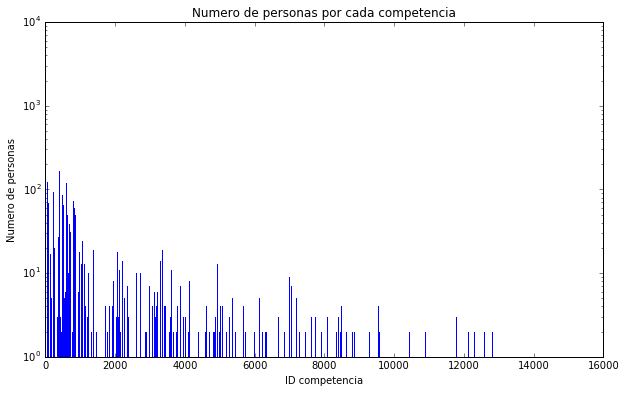

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(count_skill.shape[0]),count_skill, edgecolor="none", color="blue")
plt.xlabel("ID competencia")
plt.ylabel("Numero de personas")
plt.yscale('log')
plt.title("Numero de personas por cada competencia")
plt.show()

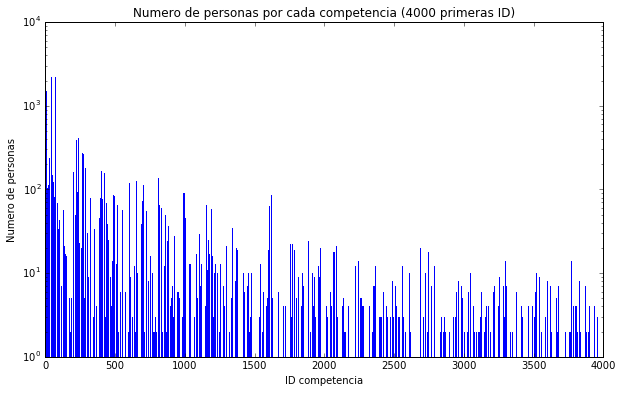

In [5]:
plt.figure(figsize=(10, 6))
N=4000
plt.bar(np.arange(N),count_skill[:N], edgecolor="none", color="blue")
plt.xlabel("ID competencia")
plt.ylabel("Numero de personas")
plt.yscale('log')
plt.title("Numero de personas por cada competencia (4000 primeras ID)")
plt.show()

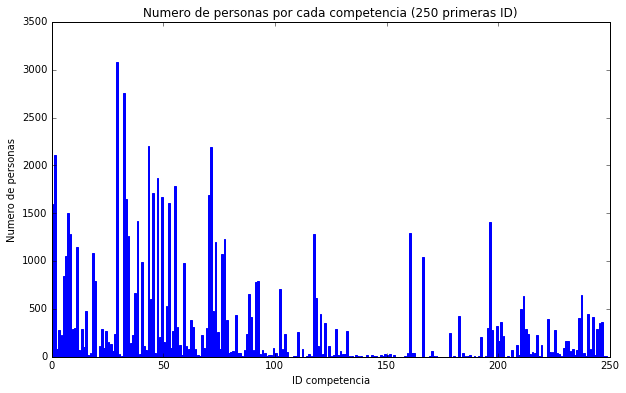

In [6]:
plt.figure(figsize=(10, 6))
N=250
plt.bar(np.arange(N),count_skill[:N],edgecolor="blue")
plt.xlabel("ID competencia")
plt.ylabel("Numero de personas")
plt.title("Numero de personas por cada competencia (250 primeras ID)")
plt.show()

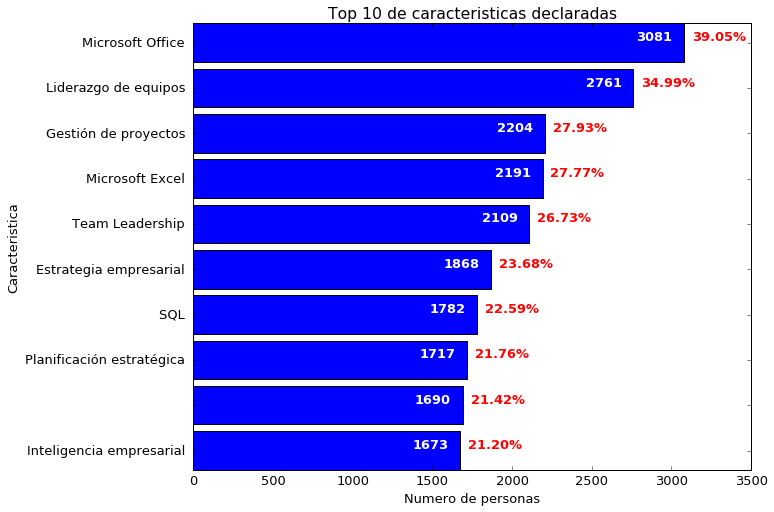

In [7]:
N=10
a=sorted(count_skill, reverse=True)
a=a[:N]
best=[]
for i in a:
    best.append(skill_tags[np.nonzero(count_skill==i)[0][0]].decode("utf-8"))
    
wid=0.85
plt.rcParams['font.size'] = 13
X=np.arange(N)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_yticks(X)
ax.set_yticklabels(best)
for i, v in enumerate(a):
    ax.text(v-300, i-.05 , str(v), color='white', fontweight='bold')
    ax.text(v + 50, i -.05, "{:.2f}".format(float(v)/Zmatrix.shape[0]*100.)+"%", color='red', fontweight='bold')
plt.barh(X,a,wid,align="center")
plt.gca().invert_yaxis()
plt.xlabel("Numero de personas")
plt.ylabel("Caracteristica")
plt.title("Top 10 de caracteristicas declaradas")
plt.show()

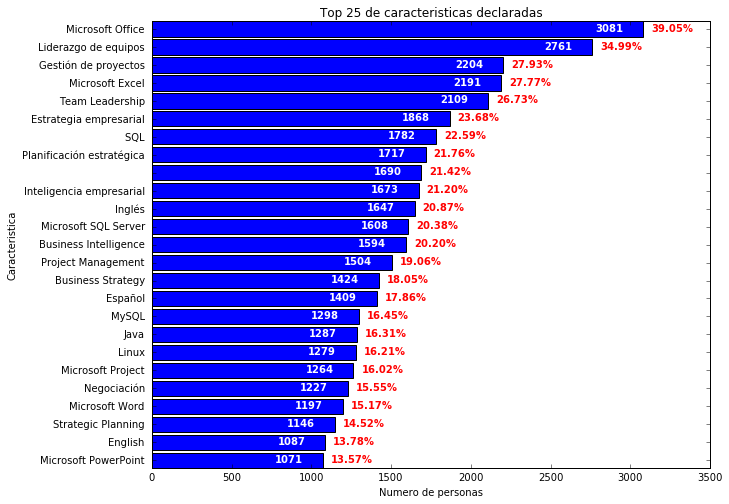

In [8]:
N=25
a=sorted(count_skill, reverse=True)
a=a[:N]
best=[]
for i in a:
    best.append(skill_tags[np.nonzero(count_skill==i)[0][0]].decode("utf-8"))
    
wid=0.85
plt.rcParams['font.size'] = 10
X=np.arange(N)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_yticks(X)
ax.set_yticklabels(best)
for i, v in enumerate(a):
    ax.text(v-300, i+.1 , str(v), color='white', fontweight='bold')
    ax.text(v + 50, i +.1, "{:.2f}".format(float(v)/Zmatrix.shape[0]*100.)+"%", color='red', fontweight='bold')
plt.barh(X,a,wid,align="center")
plt.gca().invert_yaxis()
plt.xlabel("Numero de personas")
plt.ylabel("Caracteristica")
plt.title("Top 25 de caracteristicas declaradas")
plt.show()

In [9]:
comp_e=6

y_tr=Ztr.getcol(comp_e).toarray().ravel()
y_test=Ztest.getcol(comp_e).toarray().ravel()

all_cols = np.arange(Ztr.shape[1])
cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, comp_e)))[0]

x_tr = Ztr[:, cols_to_keep]
x_test=Ztest[:, cols_to_keep]

In [10]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

tr_err=[]
test_err=[]
    
def score_the_model(model,x,y,xt,yt,text,rep=1):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt,yt)
    if rep==1:
        print "Training Accuracy %s: %f"%(text,acc_tr)
        print "Test Accuracy %s: %f"%(text,acc_test)
        print "Detailed Analysis Testing Results ..."
        print(classification_report(yt, model.predict(xt), target_names=['0','1']))
    return acc_tr,acc_test


model = LogisticRegression(penalty='l2')
model = model.fit(x_tr, y_tr)
a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Logistic Regression")
tr_err.append(a)
test_err.append(b)
print("-------------------------------------")

model = BernoulliNB()
model = model.fit(x_tr, y_tr)
a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Naive Bayes")
tr_err.append(a)
test_err.append(b)
print("-------------------------------------")

model = MultinomialNB()
model = model.fit(x_tr, y_tr)
a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Multinomial Naive Bayes")
tr_err.append(a)
test_err.append(b)
print("-------------------------------------")

model = LinearSVC()
model = model.fit(x_tr, y_tr)
a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"SVM")
tr_err.append(a)
test_err.append(b)
print("-------------------------------------")


model = KNeighborsClassifier()
model = model.fit(x_tr, y_tr)
a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"KNN")
tr_err.append(a)
test_err.append(b)

Training Accuracy Logistic Regression: 0.982256
Test Accuracy Logistic Regression: 0.930292
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      1358
          1       0.80      0.67      0.73       220

avg / total       0.93      0.93      0.93      1578

-------------------------------------
Training Accuracy Naive Bayes: 0.916667
Test Accuracy Naive Bayes: 0.899240
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1358
          1       0.64      0.63      0.64       220

avg / total       0.90      0.90      0.90      1578

-------------------------------------
Training Accuracy Multinomial Naive Bayes: 0.906686
Test Accuracy Multinomial Naive Bayes: 0.878327
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          0       0.96      0.90      0.93      1358
     

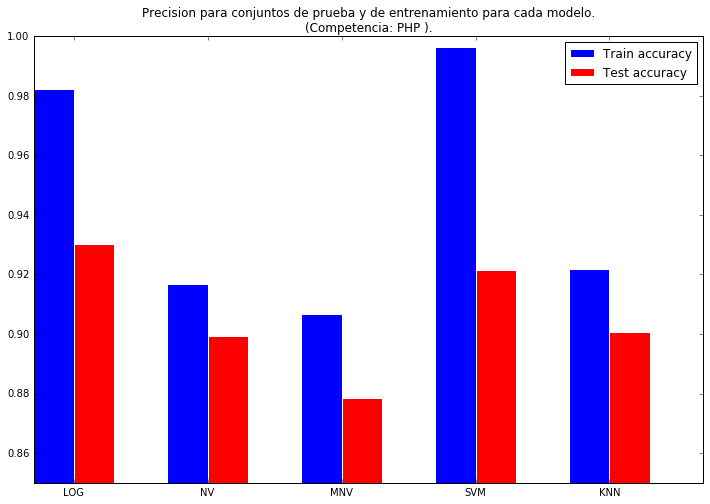

In [11]:
X=np.arange(len(tr_err))
wid = 0.3

fig= plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)


r1=ax.bar(X, np.array(tr_err),wid, color='b', edgecolor='white',label="Train accuracy")
r2=ax.bar(X+wid, np.array(test_err),wid, color='r', edgecolor='white',label="Test accuracy")

plt.title('Precision para conjuntos de prueba y de entrenamiento para cada modelo.\n(Competencia: '+skill_tags[comp_e]+').')
plt.xticks(X + wid,("LOG","NV","MNV","SVM","KNN"))

plt.ylim((0.85, 1))

plt.legend(loc="best")
plt.show()

In [12]:
def analisis_competencias(comp,porc_train,Zmatrix):
    tr_err=[]
    test_err=[]
    
    Ztr,Ztest=extrae_tr_test(Zmatrix, porc_train)
    
    y_tr=Ztr.getcol(comp).toarray().ravel()
    y_test=Ztest.getcol(comp).toarray().ravel()

    all_cols = np.arange(Ztr.shape[1])
    cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, comp)))[0]

    x_tr = Ztr[:, cols_to_keep]
    x_test=Ztest[:, cols_to_keep]
    
    model = LogisticRegression(penalty='l2')
    model = model.fit(x_tr, y_tr)
    a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Logistic Regression",0)
    tr_err.append(a)
    test_err.append(b)

    model = BernoulliNB()
    model = model.fit(x_tr, y_tr)
    a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Naive Bayes",0)
    tr_err.append(a)
    test_err.append(b)

    model = MultinomialNB()
    model = model.fit(x_tr, y_tr)
    a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"Multinomial Naive Bayes",0)
    tr_err.append(a)
    test_err.append(b)

    model = LinearSVC()
    model = model.fit(x_tr, y_tr)
    a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"SVM",0)
    tr_err.append(a)
    test_err.append(b)

    model = KNeighborsClassifier()
    model = model.fit(x_tr, y_tr)
    a,b=score_the_model(model,x_tr,y_tr,x_test,y_test,"KNN",0)
    tr_err.append(a)
    test_err.append(b)
    
    return tr_err, test_err

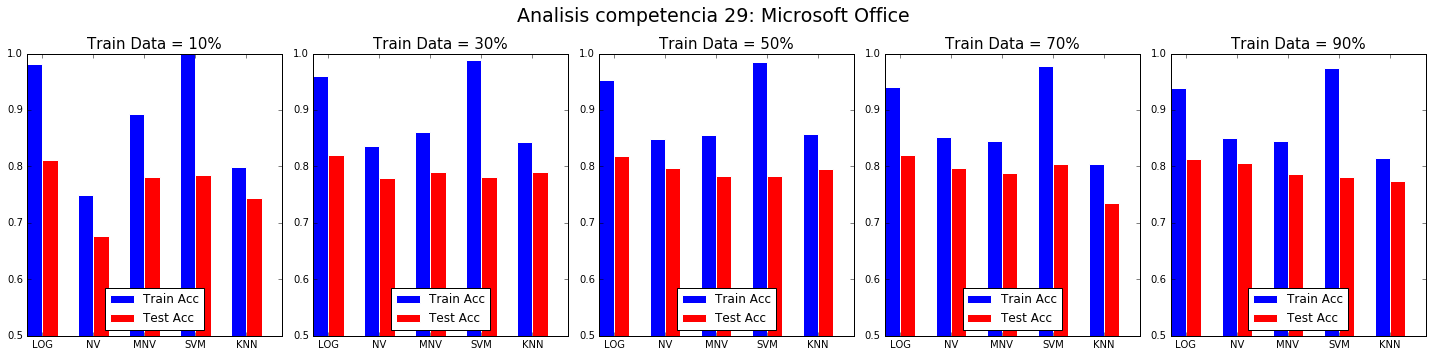

In [13]:
comp=29
c=0
f, ax = plt.subplots(1, 5, sharey=False, figsize=(20,5))
f.suptitle("Analisis competencia "+str(comp)+": "+skill_tags[comp]+("\n\n"), fontsize=19)

for i in range(1,10,2):    
    tr_acc,test_acc = analisis_competencias(comp,i/10.,Zmatrix)
    X=np.arange(len(tr_acc))
    wid = 0.3
    
    r1=ax[c].bar(X, tr_acc, wid, color='b', edgecolor='white',label="Train Acc")
    r2=ax[c].bar(X+wid, test_acc, wid, color='r', edgecolor='white', label="Test Acc")
    
     
    ax[c].set_title('Train Data = '+str(i*10)+"%",fontsize=15)
    ax[c].set_xticks(X + wid)
    ax[c].set_xticklabels(["LOG","NV","MNV","SVM","KNN"])
    ax[c].set_ylim((0.5, 1))
    ax[c].legend(loc=8)
    c+=1    
    
f.tight_layout()
f.subplots_adjust(top=0.85)

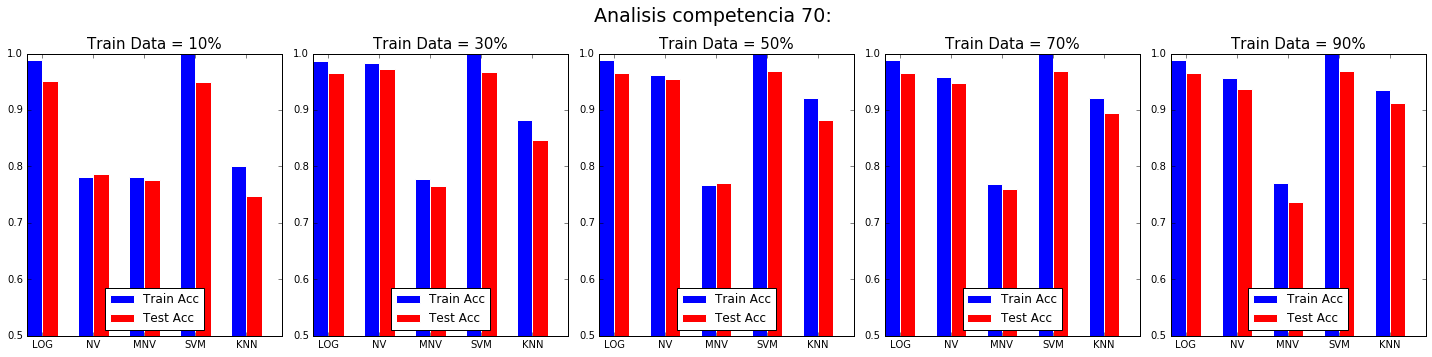

In [14]:
comp=70
c=0
f, ax = plt.subplots(1, 5, sharey=False, figsize=(20,5))
f.suptitle("Analisis competencia "+str(comp)+": "+skill_tags[comp]+("\n\n"), fontsize=19)

for i in range(1,10,2):    
    tr_acc,test_acc = analisis_competencias(comp,i/10.,Zmatrix)
    X=np.arange(len(tr_acc))
    wid = 0.3
    
    r1=ax[c].bar(X, tr_acc, wid, color='b', edgecolor='white',label="Train Acc")
    r2=ax[c].bar(X+wid, test_acc, wid, color='r', edgecolor='white', label="Test Acc")
    
     
    ax[c].set_title('Train Data = '+str(i*10)+"%",fontsize=15)
    ax[c].set_xticks(X + wid)
    ax[c].set_xticklabels(["LOG","NV","MNV","SVM","KNN"])
    ax[c].set_ylim((0.5, 1))
    ax[c].legend(loc=8)
    c+=1    
    
f.tight_layout()
f.subplots_adjust(top=0.85)

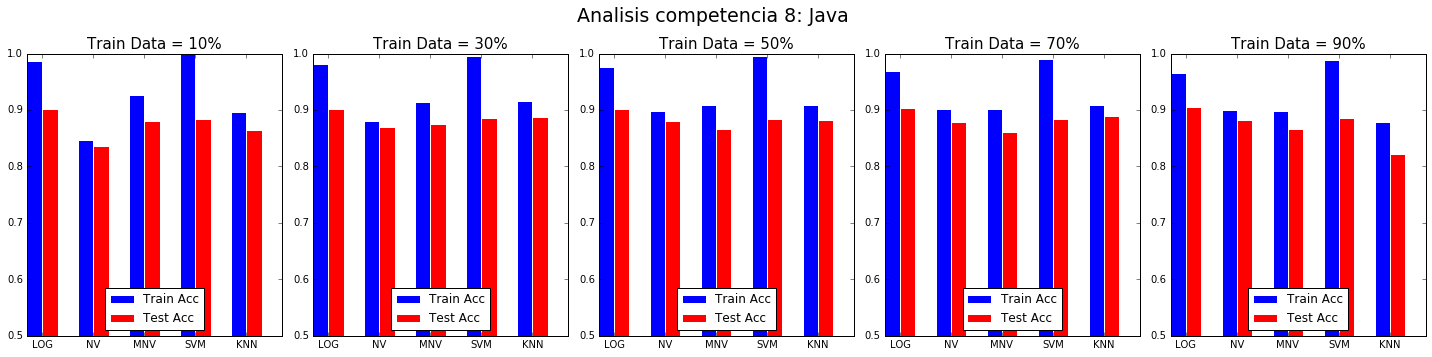

In [15]:
comp=8
c=0
f, ax = plt.subplots(1, 5, sharey=False, figsize=(20,5))
f.suptitle("Analisis competencia "+str(comp)+": "+skill_tags[comp]+("\n\n"), fontsize=19)

for i in range(1,10,2):    
    tr_acc,test_acc = analisis_competencias(comp,i/10.,Zmatrix)
    X=np.arange(len(tr_acc))
    wid = 0.3
    
    r1=ax[c].bar(X, tr_acc, wid, color='b', edgecolor='white',label="Train Acc")
    r2=ax[c].bar(X+wid, test_acc, wid, color='r', edgecolor='white', label="Test Acc")
    
     
    ax[c].set_title('Train Data = '+str(i*10)+"%",fontsize=15)
    ax[c].set_xticks(X + wid)
    ax[c].set_xticklabels(["LOG","NV","MNV","SVM","KNN"])
    ax[c].set_ylim((0.5, 1))
    ax[c].legend(loc=8)
    c+=1    
    
f.tight_layout()
f.subplots_adjust(top=0.85)

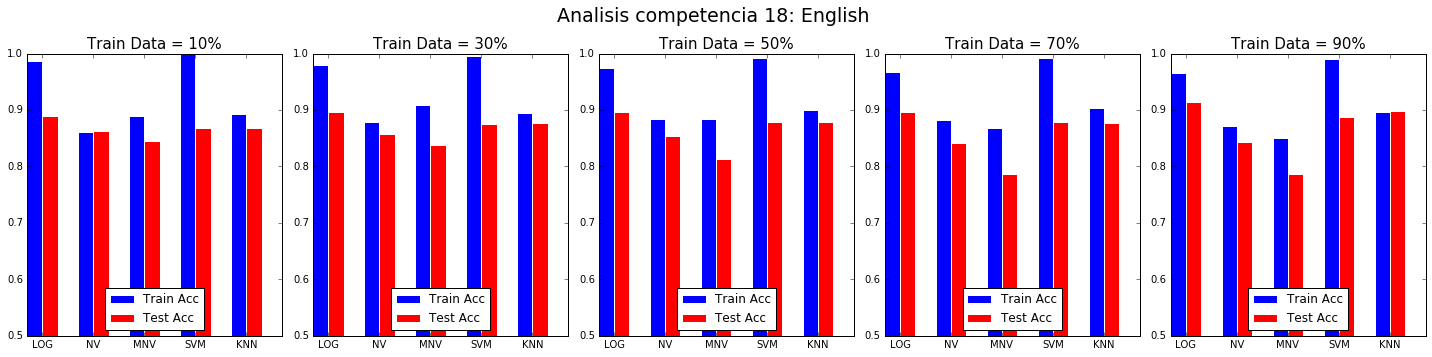

In [16]:
comp=18
c=0
f, ax = plt.subplots(1, 5, sharey=False, figsize=(20,5))
f.suptitle("Analisis competencia "+str(comp)+": "+skill_tags[comp]+("\n\n"), fontsize=19)

for i in range(1,10,2):    
    tr_acc,test_acc = analisis_competencias(comp,i/10.,Zmatrix)
    X=np.arange(len(tr_acc))
    wid = 0.3
    
    r1=ax[c].bar(X, tr_acc, wid, color='b', edgecolor='white',label="Train Acc")
    r2=ax[c].bar(X+wid, test_acc, wid, color='r', edgecolor='white', label="Test Acc")
    
     
    ax[c].set_title('Train Data = '+str(i*10)+"%",fontsize=15)
    ax[c].set_xticks(X + wid)
    ax[c].set_xticklabels(["LOG","NV","MNV","SVM","KNN"])
    ax[c].set_ylim((0.5, 1))
    ax[c].legend(loc=8)
    c+=1    
    
f.tight_layout()
f.subplots_adjust(top=0.85)